In [129]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.linear_model import Ridge

from rich.progress import track

In [161]:
def arma(T, a, b, sigma):
    e = sigma*np.random.normal(size=T)
    for t in range(1,T):
        e[t] = a*e[t-1] + e[t]
    
    x = np.zeros(T)
    x[0] = e[0]
    for t in range(1,T):
        x[t] = b*x[t-1] + e[t]
        
    return x

## Model
* Let $r_t$ be stock returns and $\beta_t$ be the barra exposure
* Assuming $r_t = g_\theta(\beta_t) \, S_t + \epsilon_t$
* Dimension of $g_\theta(\beta_t)$ is $n \times k$, where $k$ can be larger or smaller than $p$
* I use a neural net to fit $g_\theta$ from $r_t$ and $S_t$
* Once $g_\theta$ is found, I use ridge to fit $S_t$
* Repeat until correl between predicted and true does not move

## Definition of `BarraNet`

In [144]:
class BarraNet(nn.Module):
    def __init__(self, n, p, k, hidden_dims=[512, 256, 128]):
        super().__init__()
        self.n = n
        self.p = p
        self.k = k  # Output matrix has k columns
        
        # Network that processes beta to produce transformation
        layers = []
        input_dim = n * p  # flattened beta
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
            ])
            input_dim = hidden_dim
        
        # Output produces n*k values (reshaped to n x k matrix)
        layers.append(nn.Linear(input_dim, n * k))
        self.network = nn.Sequential(*layers)
    
    def g(self, beta):
        """
        Extract g(beta) - the learned transformation function
        beta: (batch, n, p)
        returns: (batch, n, k) - the transformation matrix
        """
        batch_size = beta.shape[0]
        beta_flat = beta.reshape(batch_size, -1)
        g_flat = self.network(beta_flat)  # (batch, n*k)
        return g_flat.reshape(batch_size, self.n, self.k)  # (batch, n, k)
    
    def forward(self, beta, R):
        # beta: (batch, n, p)
        # R: (batch, k)  # NOTE: R must now have k columns
        
        # Get g(beta) as (batch, n, k) matrix
        g_beta = self.g(beta)  # (batch, n, k)
        
        # Matrix multiplication: (batch, n, k) @ (batch, k, 1) -> (batch, n, 1)
        r_pred = torch.bmm(g_beta, R.unsqueeze(-1)).squeeze(-1)  # (batch, n)
        
        return r_pred

## Generate Random Data

In [276]:
%%time

T = 25
n = 1000
p = 20

## set seed
np.random.seed(56)

## set beta[t]
beta = np.zeros((T,n,p))
for i in range(n):
    for j in range(p):
        beta[:,i,j] = arma(T, a=0.95, b=0.95, sigma=0.025)

for t in range(T):
    for j in range(p):
        beta[t,:,j] = (beta[t,:,j] - beta[t,:,j].mean()) / beta[t,:,j].std()

## R[t] and e[t]
R = np.random.randn(T,p)
e = np.random.randn(T,n)

r = np.zeros((T,n))
r_expl = np.zeros((T,n))
for t in range(T):
    r[t] = beta[t] @ R[t] + 5*e[t]
    r_expl[t] = beta[t] @ R[t]

rho_expl = np.zeros(T)
for t in range(T):
    rho_expl[t] = np.corrcoef(r[t], r_expl[t])[0,1]
rho_expl_avg = np.mean(rho_expl)
print(rho_expl_avg)

0.6795867697454266
CPU times: user 207 ms, sys: 6.22 ms, total: 213 ms
Wall time: 208 ms


## Fit

In [277]:
%%time

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

## model dimension
k = 20

# Convert your data to tensors
r_data = torch.from_numpy(r).float().to(device)
beta_data = torch.from_numpy(beta).float().to(device)

## nb_iter
nb_iter = 100

rho_avg = np.zeros(nb_iter)

## Initialize S_hat
S_hat = np.random.randn(T,k)
S_data = torch.from_numpy(S_hat).float().to(device)

for l in track(range(nb_iter)):

    # Create model
    model = BarraNet(n, p, k, hidden_dims=[64, 32]).to(device)

    #model = BarraNet(n, p, k, hidden_dims=[512, 256, 128])
    
    ## Optim
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Training loop
    batch_size = 20
    num_epochs = 50
    
    for epoch in range(num_epochs):
        # Simple batch training
        indices = torch.randperm(T)
        total_loss = 0
        
        for i in range(0, T, batch_size):
            batch_idx = indices[i:i+batch_size]
            
            beta_batch = beta_data[batch_idx]
            S_batch = S_data[batch_idx]
            r_batch = r_data[batch_idx]
            
            # Forward pass
            r_pred = model(beta_batch, S_batch)
            loss = criterion(r_pred, r_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        g_beta = model.g(beta_data)
        r_pred = model(beta_data, S_data)
    
#    g_beta_np = g_beta.detach().numpy()
#    r_np = r_data.numpy()
#    r_pred_np = r_pred.numpy()

    g_beta_np = g_beta.cpu().detach().numpy()
    r_np = r_data.cpu().numpy()
    r_pred_np = r_pred.cpu().numpy()
    
    rho = np.zeros(T)
    for t in range(T):
        rho[t] = np.corrcoef(r[t], r_pred_np[t])[0,1]
    rho_avg[l] = np.mean(rho)
    
    S_hat = np.array([Ridge(alpha=1.0, fit_intercept=False).fit(g_beta_np[t], r_np[t]).coef_ for t in range(len(r_data))])
    S_data = torch.from_numpy(S_hat).float().to(device)    

Output()

CPU times: user 1min 2s, sys: 16 s, total: 1min 18s
Wall time: 38.5 s


Text(0.5, 1.0, 'Alternate NN and Ridge\n')

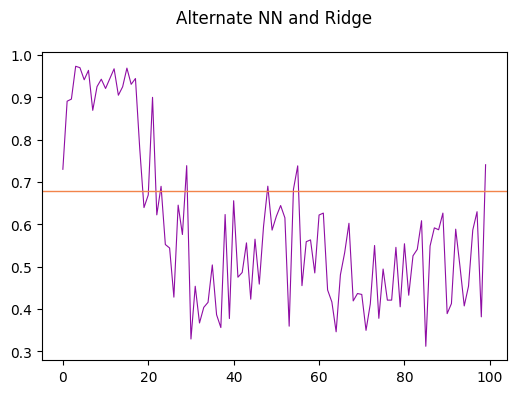

In [278]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(nb_iter), rho_avg, color=cm.plasma(0.3), lw=0.8)
ax.axhline(y=rho_expl_avg, color=cm.plasma(0.7), lw=1.)
ax.set_title("Alternate NN and Ridge\n")

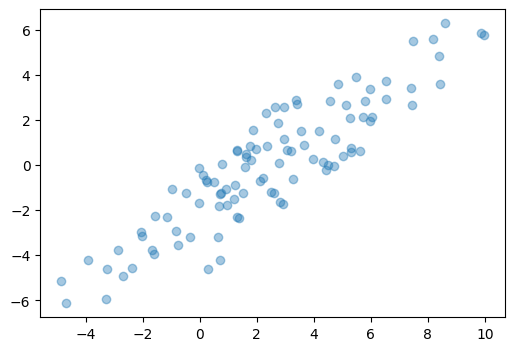

In [275]:
fig, ax = plt.subplots(figsize=(6,4))

t = 6
ax.plot(r[t], r_expl[t], "o", alpha=0.4)

## Testing
* Generate non linear data
* Train with T/2 and test with T/2

In [290]:
%%time

T = 25
n = 1000
p = 20

## set seed
np.random.seed(56)

## set beta[t]
beta = np.zeros((T,n,p))
for i in range(n):
    for j in range(p):
        beta[:,i,j] = arma(T, a=0.95, b=0.95, sigma=0.025)

for t in range(T):
    for j in range(p):
        beta[t,:,j] = (beta[t,:,j] - beta[t,:,j].mean()) / beta[t,:,j].std()

## R[t] and e[t]
R = np.random.randn(T,p)
e = np.random.randn(T,n)

r = np.zeros((T,n))
r_expl = np.zeros((T,n))
for t in range(T):
    r[t] = (beta[t]*beta[t]) @ R[t] + 1*e[t]
    r_expl[t] = (beta[t]*beta[t]) @ R[t]

rho_expl = np.zeros(T)
for t in range(T):
    rho_expl[t] = np.corrcoef(r[t], r_expl[t])[0,1]
rho_expl_avg = np.mean(rho_expl)
print(rho_expl_avg)

0.987885501010487
CPU times: user 204 ms, sys: 12.9 ms, total: 217 ms
Wall time: 204 ms


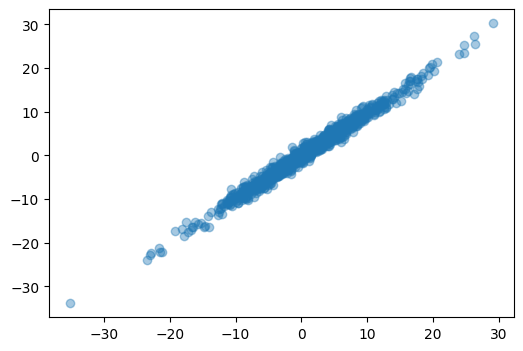

In [291]:
fig, ax = plt.subplots(figsize=(6,4))

t = 20
ax.plot(r[t], r_expl[t], "o", alpha=0.4)

In [295]:
%%time

# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"

## model dimension
k = 20

# Convert your data to tensors
r_data = torch.from_numpy(r).float().to(device)
beta_data = torch.from_numpy(beta).float().to(device)

## nb_iter
nb_iter = 100

rho_avg = np.zeros(nb_iter)

## Initialize S_hat
S_hat = np.random.randn(T,k)
S_data = torch.from_numpy(S_hat).float().to(device)

for l in track(range(nb_iter)):

    # Create model
    #model = BarraNet(n, p, k, hidden_dims=[64, 32]).to(device)

    model = BarraNet(n, p, k, hidden_dims=[512, 256, 128])
    
    ## Optim
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Training loop
    batch_size = 20
    num_epochs = 50
    
    for epoch in range(num_epochs):
        # Simple batch training
        indices = torch.randperm(T)
        total_loss = 0
        
        for i in range(0, T, batch_size):
            batch_idx = indices[i:i+batch_size]
            
            beta_batch = beta_data[batch_idx]
            S_batch = S_data[batch_idx]
            r_batch = r_data[batch_idx]
            
            # Forward pass
            r_pred = model(beta_batch, S_batch)
            loss = criterion(r_pred, r_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
    model.eval()
    with torch.no_grad():
        g_beta = model.g(beta_data)
        r_pred = model(beta_data, S_data)
    
#    g_beta_np = g_beta.detach().numpy()
#    r_np = r_data.numpy()
#    r_pred_np = r_pred.numpy()

    g_beta_np = g_beta.cpu().detach().numpy()
    r_np = r_data.cpu().numpy()
    r_pred_np = r_pred.cpu().numpy()
    
    rho = np.zeros(T)
    for t in range(T):
        rho[t] = np.corrcoef(r[t], r_pred_np[t])[0,1]
    rho_avg[l] = np.mean(rho)
    
    S_hat = np.array([Ridge(alpha=0., fit_intercept=False).fit(g_beta_np[t], r_np[t]).coef_ for t in range(len(r_data))])
    S_data = torch.from_numpy(S_hat).float().to(device)    

Output()

CPU times: user 7min 47s, sys: 1min 15s, total: 9min 3s
Wall time: 3min 28s


Text(0.5, 1.0, 'Alternate NN and Ridge\n')

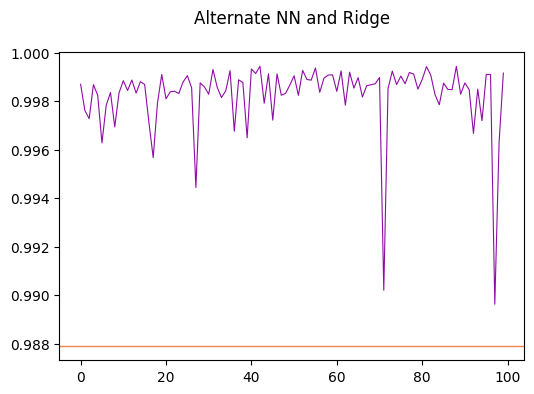

In [296]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(nb_iter), rho_avg, color=cm.plasma(0.3), lw=0.8)
ax.axhline(y=rho_expl_avg, color=cm.plasma(0.7), lw=1.)
ax.set_title("Alternate NN and Ridge\n")